# Install SageMaker Experiments

In [ ]:
!pip install sagemaker-experiments

# Simple Experiments

In [12]:
from sagemaker import get_execution_role
from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
import time
from sagemaker.tensorflow import TensorFlow

role = get_execution_role()
input_uri = 's3://sagemaker-us-east-1-233037139193/mbp3/dataset/dataset.pkl.gz'

## Experiments creation

In [13]:
my_experiment = Experiment.create(experiment_name="my-private-exp3",
                                  description="It's private")
print(my_experiment)

Experiment(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7fa8b81a27b8>,experiment_name='my-private-exp3',description="It's private",experiment_arn='arn:aws:sagemaker:us-east-1:233037139193:experiment/my-private-exp3',response_metadata={'RequestId': 'f7454d0e-f2cc-4dc5-86b0-81bb609a2a77', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'f7454d0e-f2cc-4dc5-86b0-81bb609a2a77', 'content-type': 'application/x-amz-json-1.1', 'content-length': '87', 'date': 'Thu, 02 Jul 2020 00:08:39 GMT'}, 'RetryAttempts': 0})


In [14]:
%%writefile mnist_softmax.py
import tensorflow as tf
import argparse
import os, time
import numpy as np
import json
import gzip, pickle

if __name__ == "__main__":
    
    start = time.time()
    parser = argparse.ArgumentParser()
    parser.add_argument('--model_dir', type=str)
    parser.add_argument('--sm-model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAINING'))
    parser.add_argument('--hosts', type=list, default=json.loads(os.environ.get('SM_HOSTS')))
    parser.add_argument('--current-host', type=str, default=os.environ.get('SM_CURRENT_HOST'))  
    args, _ = parser.parse_known_args()

    input_path = os.path.join(args.train, 'dataset.pkl.gz')
    with gzip.open(input_path, 'rb') as f:
        train_data, train_label, test_data, test_label = pickle.load(f)
        
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.fit(train_data, train_label, epochs=3, verbose=2)
    model.evaluate(test_data, test_label, verbose=0)
    
    model.save(os.path.join(args.sm_model_dir, '000000001'), 'my_model.h5')
        
    print("training time: {}".format(time.time() - start))

Overwriting mnist_softmax.py


In [15]:
%%writefile mnist_simple_nn.py
import tensorflow as tf
import argparse
import os, time
import numpy as np
import json
import gzip, pickle

if __name__ == "__main__":
    
    start = time.time()
    parser = argparse.ArgumentParser()
    parser.add_argument('--model_dir', type=str)
    parser.add_argument('--sm-model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAINING'))
    parser.add_argument('--hosts', type=list, default=json.loads(os.environ.get('SM_HOSTS')))
    parser.add_argument('--current-host', type=str, default=os.environ.get('SM_CURRENT_HOST'))  
    args, _ = parser.parse_known_args()

    input_path = os.path.join(args.train, 'dataset.pkl.gz')
    with gzip.open(input_path, 'rb') as f:
        train_data, train_label, test_data, test_label = pickle.load(f)
        
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.fit(train_data, train_label, epochs=3, verbose=2)
    model.evaluate(test_data, test_label, verbose=0)
    
    model.save(os.path.join(args.sm_model_dir, '000000001'), 'my_model.h5')
        
    print("training time: {}".format(time.time() - start))

Overwriting mnist_simple_nn.py


## Trial creation & run

In [19]:
trial_name = f"simple-nn-64-{int(time.time())}"
trial = Trial.create(trial_name=trial_name, 
                     experiment_name=my_experiment.experiment_name)

In [20]:
estimator = TensorFlow(entry_point='mnist_simple_nn.py',
                       role=role,
                       train_instance_count=1,
                       train_instance_type='ml.m5.xlarge',
                       train_use_spot_instances = True,
                       train_max_run = 600,
                       train_max_wait = 1200,                     
                       framework_version='2.1.0',
                       py_version='py3')

In [21]:
estimator.fit(inputs=input_uri,
              job_name=trial_name,
              experiment_config={
                  "TrialName": trial.trial_name,
                  "TrialComponentDisplayName": "Training"
              })

2020-07-02 00:17:25 Starting - Starting the training job...
2020-07-02 00:17:27 Starting - Launching requested ML instances.........
2020-07-02 00:19:14 Starting - Preparing the instances for training......
2020-07-02 00:20:26 Downloading - Downloading input data
2020-07-02 00:20:26 Training - Training image download completed. Training in progress...2020-07-02 00:20:29,689 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-07-02 00:20:29,696 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-07-02 00:20:36,758 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-07-02 00:20:36,786 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-07-02 00:20:36,811 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-07-02 00:20:36,827 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters"

## Evaluate trials

In [42]:
search_expression = {
    "Filters":[
        {
            "Name": "DisplayName",
            "Operator": "Equals",
            "Value": "Training",
        }
    ],
}

In [25]:
from sagemaker.analytics import ExperimentAnalytics
#experiment_name = "my-private-exp3"
trial_component_analytics = ExperimentAnalytics(
    experiment_name=my_experiment.experiment_name,
    #experiment_name=experiment_name,
    search_expression=search_expression,
    sort_by="metrics.accuracy_EVAL.max",
    sort_order="Descending",
    metric_names=['accuracy_EVAL', 'loss_EVAL'],
    parameter_names=['SageMaker.InstanceType', 'sagemaker_program']
)

In [26]:
trial_component_analytics.dataframe()

,TrialComponentName,DisplayName,SourceArn,SageMaker.InstanceType,sagemaker_program,accuracy_EVAL - Min,accuracy_EVAL - Max,accuracy_EVAL - Avg,accuracy_EVAL - StdDev,accuracy_EVAL - Last,accuracy_EVAL - Count,loss_EVAL - Min,loss_EVAL - Max,loss_EVAL - Avg,loss_EVAL - StdDev,loss_EVAL - Last,loss_EVAL - Count
0,simple-nn-64-1593649040-aws-training-job,Training,arn:aws:sagemaker:us-east-1:233037139193:training-job/simple-nn-64-1593649040,ml.m5.xlarge,"""mnist_simple_nn.py""",0.90625,0.90625,0.90625,0.0,0.90625,1,0.173379,0.173379,0.173379,0.0,0.173379,1
1,softmax-1593648549-aws-training-job,Training,arn:aws:sagemaker:us-east-1:233037139193:training-job/softmax-1593648549,ml.m5.xlarge,"""mnist_softmax.py""",0.87500,0.87500,0.87500,0.0,0.87500,1,0.280480,0.280480,0.280480,0.0,0.280480,1


# Debugger

In [ ]:
! pip install smdebug

In [27]:
from smdebug.trials import create_trial
debug_trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2020-07-02 00:29:01.315 ip-172-16-101-108:30216 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-233037139193/simple-nn-64-1593649040/debug-output


In [28]:
debug_trial.tensor_names()

[2020-07-02 00:29:03.218 ip-172-16-101-108:30216 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2020-07-02 00:29:04.242 ip-172-16-101-108:30216 INFO trial.py:210] Loaded all steps


['accuracy', 'batch', 'loss', 'size']

In [29]:
debug_trial.tensor_names(collection="losses")

['loss']

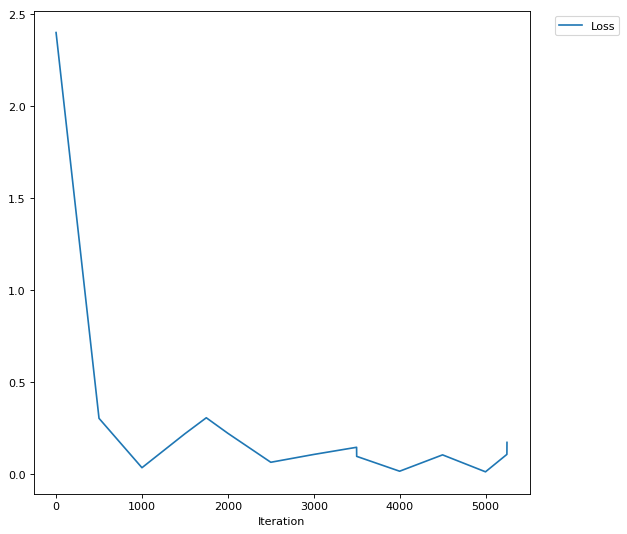

In [31]:
import matplotlib.pyplot as plt
#import re

plt.figure(
    num=1, figsize=(8, 8), dpi=80,
    facecolor='w', edgecolor='k')

tensor = debug_trial.tensor('loss')
steps = tensor.steps()
data = [tensor.value(s) for s in steps]

plt.plot(steps, data, label='Loss')

plt.legend(bbox_to_anchor=(1.04,1), loc='upper left')
plt.xlabel('Iteration')
plt.ylabel('')
plt.show()

# Hyperparameter trial loop

In [22]:
%%writefile mnist_simple_nn_h.py
import tensorflow as tf
import argparse
import os, time
import numpy as np
import json
import gzip, pickle

if __name__ == "__main__":
    
    start = time.time()
    parser = argparse.ArgumentParser()
    parser.add_argument('--model_dir', type=str)
    parser.add_argument('--sm-model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAINING'))
    parser.add_argument('--hosts', type=list, default=json.loads(os.environ.get('SM_HOSTS')))
    parser.add_argument('--current-host', type=str, default=os.environ.get('SM_CURRENT_HOST'))
    parser.add_argument('--number-of-nodes', type=int, default=128) # parameterize
    args, _ = parser.parse_known_args()

    input_path = os.path.join(args.train, 'dataset.pkl.gz')
    with gzip.open(input_path, 'rb') as f:
        train_data, train_label, test_data, test_label = pickle.load(f)
        
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(args.number_of_nodes, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.fit(train_data, train_label, epochs=3, verbose=2)
    model.evaluate(test_data, test_label, verbose=0)
    
    model.save(os.path.join(args.sm_model_dir, '000000001'), 'my_model.h5')
        
    print("training time: {}".format(time.time() - start))

Overwriting mnist_simple_nn_h.py


In [ ]:
for _, number_of_nodes in enumerate([32, 128]):
    trial_name = f"simple-nn-{number_of_nodes}-{int(time.time())}"
    trial = Trial.create(trial_name=trial_name, 
                         experiment_name=my_experiment.experiment_name)
    
    estimator = TensorFlow(entry_point='mnist_simple_nn_h.py',
                           role=role,
                           train_instance_count=1,
                           train_instance_type='ml.m5.xlarge',
                           hyperparameters={
                               'number_of_nodes': number_of_nodes
                           },
                           train_use_spot_instances = True,
                           train_max_run = 600,
                           train_max_wait = 1200,
                           framework_version='2.1.0',
                           py_version='py3')
                           
    estimator.fit(inputs=input_uri,
                  job_name=trial_name,
                  experiment_config={
                      "TrialName": trial.trial_name,
                      "TrialComponentDisplayName": "Training"
                  })
    time.sleep(2)

2020-07-02 00:30:50 Starting - Starting the training job........
2020-07-02 00:32:12 Starting - Preparing the instances for training...
2020-07-02 00:32:51 Downloading - Downloading input data...
2020-07-02 00:33:13 Training - Downloading the training image...
2020-07-02 00:33:35 Training - Training image download completed. Training in progress.2020-07-02 00:33:40,658 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-07-02 00:33:40,665 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-07-02 00:33:41,009 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-07-02 00:33:41,024 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-07-02 00:33:41,037 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-07-02 00:33:41,046 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},

Training seconds: 77
Billable seconds: 33
Managed Spot Training savings: 57.1%
2020-07-02 00:34:35 Starting - Starting the training job...
2020-07-02 00:34:37 Starting - Launching requested ML instances......
2020-07-02 00:35:58 Starting - Preparing the instances for training......
2020-07-02 00:37:06 Downloading - Downloading input data
2020-07-02 00:37:06 Training - Downloading the training image...
2020-07-02 00:37:20 Training - Training image download completed. Training in progress.2020-07-02 00:37:25,047 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-07-02 00:37:25,054 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-07-02 00:37:32,581 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-07-02 00:37:32,596 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-07-02 00:37:32,610 sagemaker-containers INFO     No GPUs detected (normal if no gpus in


2020-07-02 00:37:59 Uploading - Uploading generated training model
2020-07-02 00:37:59 Completed - Training job completed
Training seconds: 73
Billable seconds: 31
Managed Spot Training savings: 57.5%


In [1]:
trial_analytics2 = ExperimentAnalytics(
    experiment_name=my_experiment.experiment_name,
    search_expression=search_expression,
    sort_by="metrics.accuracy_EVAL.max",
    sort_order="Descending",
    metric_names=['accuracy_EVAL', 'loss_EVAL'],
    parameter_names=['SageMaker.InstanceType', 'sagemaker_program']
)
trial_analytics2.dataframe()

NameError: name 'ExperimentAnalytics' is not defined

# Hyperparameter optimization

In [25]:
hpo_estimator = TensorFlow(entry_point='mnist_simple_nn_h.py',
                           role=role,
                           train_instance_count=1,
                           train_instance_type='ml.m5.xlarge',
                           train_use_spot_instances = True,
                           train_max_run = 600, 
                           train_max_wait = 1200,
                           framework_version='2.1.0',
                           py_version='py3')

In [26]:
from sagemaker.tuner import IntegerParameter, HyperparameterTuner

tuner = HyperparameterTuner(estimator=hpo_estimator,
                            objective_metric_name='loss',
                            objective_type='Minimize',
                            hyperparameter_ranges={
                                'number_of_nodes': IntegerParameter(32, 128)
                            },
                            metric_definitions=[{
                                'Name': 'loss',
                                'Regex': 'loss: ([0-9\\.]+)'
                            }],
                            max_jobs=10,
                            max_parallel_jobs=2, # What number is the best? 
                            early_stopping_type='Auto')

In [27]:
import time

timestamp = time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
hpo_job_name='hpo-job-{}'.format(timestamp)
tuner.fit(inputs=input_uri, job_name=hpo_job_name)

INFO:root:_TuningJob.start_new!!!
INFO:sagemaker:Creating hyperparameter tuning job with name: hpo-job-2020-07-01-05-41-03


## HPO Results

In [8]:
import boto3
sm_client = boto3.client('sagemaker')
#hpo_job_name='hpo-job-2020-07-01-05-41-03'
# run this cell to check current status of hyperparameter tuning job
tuning_job_result = sm_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=hpo_job_name)

status = tuning_job_result['HyperParameterTuningJobStatus']
if status != 'Completed':
    print('Reminder: the tuning job has not been completed.')
    
job_count = tuning_job_result['TrainingJobStatusCounters']['Completed']
print("%d training jobs have completed" % job_count)

is_minimize = (tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['Type'] != 'Maximize')
objective_name = tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['MetricName']

10 training jobs have completed


In [9]:
import pandas as pd
from sagemaker import HyperparameterTuningJobAnalytics

tuner_result = HyperparameterTuningJobAnalytics(hpo_job_name)

full_df = tuner_result.dataframe()

if len(full_df) > 0:
    df = full_df[full_df['FinalObjectiveValue'] > -float('inf')]
    if len(df) > 0:
        df = df.sort_values('FinalObjectiveValue', ascending=is_minimize)
        print("Number of training jobs with valid objective: %d" % len(df))
        print({"lowest":min(df['FinalObjectiveValue']),"highest": max(df['FinalObjectiveValue'])})
        pd.set_option('display.max_colwidth', -1)  # Don't truncate TrainingJobName        
    else:
        print("No training jobs have reported valid results yet.")
        
df

Number of training jobs with valid objective: 10
{'lowest': 0.07739999890327454, 'highest': 0.08299999684095383}


,FinalObjectiveValue,TrainingElapsedTimeSeconds,TrainingEndTime,TrainingJobName,TrainingJobStatus,TrainingStartTime,number_of_nodes
9,0.0774,58.0,2020-07-01 05:44:17+00:00,hpo-job-2020-07-01-05-41-03-001-15e269e7,Completed,2020-07-01 05:43:19+00:00,83.0
5,0.0789,82.0,2020-07-01 05:51:43+00:00,hpo-job-2020-07-01-05-41-03-005-d776786c,Completed,2020-07-01 05:50:21+00:00,46.0
4,0.0791,79.0,2020-07-01 05:52:18+00:00,hpo-job-2020-07-01-05-41-03-006-dae9e7fc,Completed,2020-07-01 05:50:59+00:00,45.0
1,0.0795,98.0,2020-07-01 05:59:09+00:00,hpo-job-2020-07-01-05-41-03-009-531f2b5c,Completed,2020-07-01 05:57:31+00:00,100.0
2,0.0797,58.0,2020-07-01 05:55:16+00:00,hpo-job-2020-07-01-05-41-03-008-3fed8142,Completed,2020-07-01 05:54:18+00:00,36.0
7,0.0809,78.0,2020-07-01 05:48:36+00:00,hpo-job-2020-07-01-05-41-03-003-b2f294e8,Completed,2020-07-01 05:47:18+00:00,79.0
8,0.0818,76.0,2020-07-01 05:44:30+00:00,hpo-job-2020-07-01-05-41-03-002-b7aba00b,Completed,2020-07-01 05:43:14+00:00,98.0
6,0.0819,63.0,2020-07-01 05:48:17+00:00,hpo-job-2020-07-01-05-41-03-004-4035d0a1,Completed,2020-07-01 05:47:14+00:00,80.0
0,0.0823,78.0,2020-07-01 05:59:09+00:00,hpo-job-2020-07-01-05-41-03-010-09002209,Completed,2020-07-01 05:57:51+00:00,109.0
3,0.0830,80.0,2020-07-01 05:55:55+00:00,hpo-job-2020-07-01-05-41-03-007-2fe97c4c,Completed,2020-07-01 05:54:35+00:00,58.0


In [10]:
# This is for showing the HPO results by time
import bokeh
import bokeh.io
bokeh.io.output_notebook()
from bokeh.plotting import figure, show
from bokeh.models import HoverTool

class HoverHelper():

    def __init__(self, tuning_analytics):
        self.tuner = tuning_analytics

    def hovertool(self):
        tooltips = [
            ("FinalObjectiveValue", "@FinalObjectiveValue"),
            ("TrainingJobName", "@TrainingJobName"),
        ]
        for k in self.tuner.tuning_ranges.keys():
            tooltips.append( (k, "@{%s}" % k) )

        ht = HoverTool(tooltips=tooltips)
        return ht

    def tools(self, standard_tools='pan,crosshair,wheel_zoom,zoom_in,zoom_out,undo,reset'):
        return [self.hovertool(), standard_tools]

hover = HoverHelper(tuner_result)

p = figure(plot_width=900, plot_height=400, tools=hover.tools(), x_axis_type='datetime')
p.circle(source=df, x='TrainingStartTime', y='FinalObjectiveValue')
show(p)

Loading BokehJS ...

In [11]:
ranges = tuner_result.tuning_ranges
figures = []
for hp_name, hp_range in ranges.items():
    categorical_args = {}
    if hp_range.get('Values'):
        # This is marked as categorical.  Check if all options are actually numbers.
        def is_num(x):
            try:
                float(x)
                return 1
            except:
                return 0           
        vals = hp_range['Values']
        if sum([is_num(x) for x in vals]) == len(vals):
            # Bokeh has issues plotting a "categorical" range that's actually numeric, so plot as numeric
            print("Hyperparameter %s is tuned as categorical, but all values are numeric" % hp_name)
        else:
            # Set up extra options for plotting categoricals.  A bit tricky when they're actually numbers.
            categorical_args['x_range'] = vals

    # Now plot it
    p = figure(plot_width=500, plot_height=500, 
               title="Objective vs %s" % hp_name,
               tools=hover.tools(),
               x_axis_label=hp_name, y_axis_label=objective_name,
               **categorical_args)
    p.circle(source=df, x=hp_name, y='FinalObjectiveValue')
    figures.append(p)
show(bokeh.layouts.Column(*figures))

# Total Experiments Result

In [35]:
experiment_name="our-experiment-3"

In [36]:
final_estimator = TensorFlow(entry_point='mnist_simple_nn_h.py',
                             role=role,
                             train_instance_count=1,
                             train_instance_type='ml.m5.xlarge',
                             hyperparameters={
                                 'number_of_nodes': 83
                             },
                             metric_definitions=[
                                 {'Name': 'Training:seconds', 'Regex': 'training time: ([0-9\\.]+)'}
                             ],
                             train_use_spot_instances = True,
                             train_max_run = 600,
                             train_max_wait = 1200,
                             framework_version='2.1.0',
                             py_version='py3')

In [37]:
my_trial_name = f"simple-nn-83-{int(time.time())}"
my_trial = Trial.create(trial_name=my_trial_name, 
                        experiment_name=experiment_name)
final_estimator.fit(inputs=input_uri,
                    job_name=my_trial_name,
                    experiment_config={
                        "TrialName": my_trial.trial_name,
                        "TrialComponentDisplayName": "Training"
                    })

2020-07-02 00:43:02 Starting - Starting the training job...
2020-07-02 00:43:04 Starting - Launching requested ML instances.........
2020-07-02 00:44:48 Starting - Preparing the instances for training...
2020-07-02 00:45:25 Downloading - Downloading input data...
2020-07-02 00:46:00 Training - Training image download completed. Training in progress..2020-07-02 00:46:03,687 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-07-02 00:46:03,696 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-07-02 00:46:35,439 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-07-02 00:46:35,454 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-07-02 00:46:35,469 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-07-02 00:46:35,478 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters":


2020-07-02 00:47:04 Completed - Training job completed
Training seconds: 99
Billable seconds: 42
Managed Spot Training savings: 57.6%


In [43]:
all_trial_analytics = ExperimentAnalytics(
    experiment_name=experiment_name,
    search_expression=search_expression,
    sort_by="metrics.accuracy_EVAL.max",
    sort_order="Descending",
    metric_names=['accuracy_EVAL', 'loss_EVAL', 'Training:seconds'],
    parameter_names=['SageMaker.InstanceType', 'sagemaker_program']
)
all_trial_analytics.dataframe()

,TrialComponentName,DisplayName,SourceArn,SageMaker.InstanceType,sagemaker_program,accuracy_EVAL - Min,accuracy_EVAL - Max,accuracy_EVAL - Avg,accuracy_EVAL - StdDev,accuracy_EVAL - Last,...,Training:seconds - Avg,Training:seconds - StdDev,Training:seconds - Last,Training:seconds - Count,loss_EVAL - Min,loss_EVAL - Max,loss_EVAL - Avg,loss_EVAL - StdDev,loss_EVAL - Last,loss_EVAL - Count
0,someone-cnn-1593579748-aws-training-job,Training,arn:aws:sagemaker:us-east-1:233037139193:training-job/someone-cnn-1593579748,ml.m5.xlarge,"""mnist_exp_cnn.py""",0.93750,0.93750,0.93750,0.0,0.93750,...,42.743571,0.0,42.743571,1,0.125143,0.125143,0.125143,0.0,0.125143,1
1,simple-nn-83-1593650581-aws-training-job,Training,arn:aws:sagemaker:us-east-1:233037139193:training-job/simple-nn-83-1593650581,ml.m5.xlarge,"""mnist_simple_nn_h.py""",0.90625,0.90625,0.90625,0.0,0.90625,...,16.744574,0.0,16.744574,1,0.147424,0.147424,0.147424,0.0,0.147424,1
